# Assignment---Investment of new restaurant in Toronto

### 1. Data pre-processing

In [1]:
# setup library
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import requests
from bs4 import BeautifulSoup

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image # converting images into arrays

print('Libraries imported.')

Libraries imported.


In [2]:
# Read Immigrants history data
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,39,39,47,71,340,496,741,828,1076,1028,1378,1170,713,858,1537,2212,2555,1999,2395,3326,4067,3697,3479,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,0,0,0,0,0,1,2,2,3,3,21,56,96,71,63,113,307,574,1264,1816,1602,1021,853,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,67,71,69,63,44,69,132,242,434,491,872,795,717,595,1106,2054,1842,2292,2389,2867,3418,3406,3072,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,0,0,0,0,0,2,0,0,0,3,0,1,0,0,0,0,0,2,0,0,1,0,2,0,0,1,1,0,0,0,0,1,1


In [3]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)


data dimensions: (195, 38)


In [4]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,741,828,1076,1028,1378,1170,713,858,1537,2212,2555,1999,2395,3326,4067,3697,3479,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,2,2,3,3,21,56,96,71,63,113,307,574,1264,1816,1602,1021,853,1450,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,132,242,434,491,872,795,717,595,1106,2054,1842,2292,2389,2867,3418,3406,3072,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,0,0,0,3,0,1,0,0,0,0,0,2,0,0,1,0,2,0,0,1,1,0,0,0,0,1,1,15


In [5]:
# group countries by continents and apply sum() function 
df_continents = df_can.groupby('Continent', axis=0).sum()

# note: the output of the groupby method is a `groupby' object. 
# we can not use it further until we apply a function (eg .sum())
print(type(df_can.groupby('Continent', axis=0)))

df_continents.head()

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Continent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Africa,3951,4363,3819,2671,2639,2650,3782,7494,7552,9894,11012,14228,19242,16531,13072,14806,15700,14471,13791,15996,20346,24292,22710,23366,28192,27523,29188,28284,29890,34534,40892,35441,38083,38543,618948
Asia,31025,34314,30214,24696,27274,23850,28739,43203,47454,60256,72829,89964,90752,98737,88852,90424,103030,106383,90929,106844,134544,148083,137653,131769,134850,159253,149054,133459,139894,141434,163845,146894,152218,155075,3317794
Europe,39760,44802,42720,24638,22287,20844,24370,46698,54726,60893,68301,57938,64123,62937,62531,55764,55642,48841,36719,35639,38215,42779,36798,34556,38082,35955,33053,33495,34692,35078,33425,26778,29177,28691,1410947
Latin America and the Caribbean,13081,15215,16769,15427,13678,15171,21179,28471,21924,25060,27942,36827,37853,33840,21341,20262,18645,17174,13830,15088,16898,20067,19317,20263,22181,24747,24676,26011,26547,26867,28818,27856,27173,24950,765148
Northern America,9378,10030,9074,7100,6661,6543,7074,7705,6469,6790,5895,6057,6846,7438,5902,4891,5516,4753,4437,5196,5433,5604,4948,5543,6990,8394,9613,9463,10190,8995,8142,7677,7892,8503,241142


### 2. Plot the Immigration data

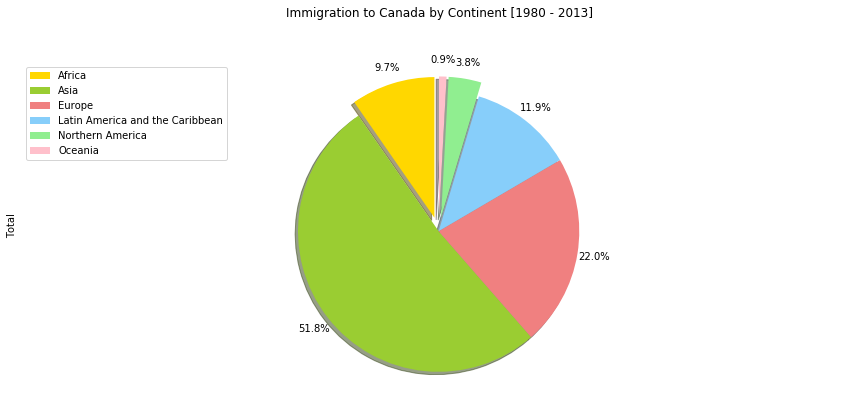

In [6]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

df_continents['Total'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Immigration to Canada by Continent [1980 - 2013]', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_continents.index, loc='upper left') 

plt.show()

In [7]:
df_top10 = df_can.sort_values(['Total'], ascending=False, axis=0).head(10)
df_top10

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
India,Asia,Southern Asia,Developing regions,8880,8670,8147,7338,5704,4211,7150,10189,11522,10343,12041,13734,13673,21496,18620,18489,23859,22268,17241,18974,28572,31223,31889,27155,28235,36210,33848,28742,28261,29456,34235,27509,30933,33087,691904
China,Asia,Eastern Asia,Developing regions,5123,6682,3308,1863,1527,1816,1960,2643,2758,4323,8076,14255,10846,9817,13128,14398,19415,20475,21049,30069,35529,36434,31961,36439,36619,42584,33518,27642,30037,29622,30391,28502,33024,34129,659962
United Kingdom of Great Britain and Northern Ireland,Europe,Northern Europe,Developed regions,22045,24796,20620,10015,10170,9564,9470,21337,27359,23795,31668,23380,34123,33720,39231,30145,29322,22965,10367,7045,8840,11728,8046,6797,7533,7258,7140,8216,8979,8876,8724,6204,6195,5827,551500
Philippines,Asia,South-Eastern Asia,Developing regions,6051,5921,5249,4562,3801,3150,4166,7360,8639,11865,12509,12718,13670,20479,19532,15864,13692,11549,8735,9734,10763,13836,11707,12758,14004,18139,18400,19837,24887,28573,38617,36765,34315,29544,511391
Pakistan,Asia,Southern Asia,Developing regions,978,972,1201,900,668,514,691,1072,1334,2261,2470,3079,4071,4777,4666,4994,9125,13073,9068,9979,15400,16708,15110,13205,13399,14314,13127,10124,8994,7217,6811,7468,11227,12603,241600
United States of America,Northern America,Northern America,Developed regions,9378,10030,9074,7100,6661,6543,7074,7705,6469,6790,5892,6054,6842,7435,5901,4890,5515,4753,4437,5196,5433,5604,4948,5543,6990,8394,9613,9463,10190,8995,8142,7676,7891,8501,241122
Iran (Islamic Republic of),Asia,Southern Asia,Developing regions,1172,1429,1822,1592,1977,1648,1794,2989,3273,3781,3655,6250,6814,3959,2785,3956,6205,7982,7057,6208,5884,6169,8129,5918,6348,5837,7480,6974,6475,6580,7477,7479,7534,11291,175923
Sri Lanka,Asia,Southern Asia,Developing regions,185,371,290,197,1086,845,1838,4447,2779,2758,3525,7266,13102,9563,7150,9368,6484,5415,3566,4982,6081,5861,5279,4892,4495,4930,4714,4123,4756,4547,4422,3309,3338,2394,148358
Republic of Korea,Asia,Eastern Asia,Developing regions,1011,1456,1572,1081,847,962,1208,2338,2805,2979,2087,2598,3790,3819,3005,3501,3250,4093,4938,7108,7618,9619,7342,7117,5352,5832,6215,5920,7294,5874,5537,4588,5316,4509,142581


In [8]:
years_80s = list(map(str, range(1980, 1990))) 
years_90s = list(map(str, range(1990, 2000))) 
years_00s = list(map(str, range(2000, 2010))) 
years_tol=list(map(str, range(1980, 2013))) 

conti=df_top10['Continent']

df_80s = df_top10.loc[:, years_80s].sum(axis=1) 
df_90s = df_top10.loc[:, years_90s].sum(axis=1) 
df_00s = df_top10.loc[:, years_00s].sum(axis=1)
df_tol=df_top10.loc[:, years_tol].sum(axis=1)

new_df = pd.DataFrame({'Continent':conti,'1980s': df_80s, '1990s': df_90s, '2000s':df_00s, 'Total':df_tol}) 
new_df.head(10)

,Continent,1980s,1990s,2000s,Total
Country,,,,,
India,Asia,82154,180395,303591,658817
China,Asia,32003,161528,340385,625833
United Kingdom of Great Britain and Northern Ireland,Europe,179171,261966,83413,545673
Philippines,Asia,60764,138482,172904,481847
Pakistan,Asia,10591,65302,127598,228997
United States of America,Northern America,76824,56915,75173,232621
Iran (Islamic Republic of),Asia,21477,54871,65794,164632
Sri Lanka,Asia,14796,70421,49678,145964
Republic of Korea,Asia,16259,38189,68183,138072


In [9]:
df_CIUK=df_can.loc[['China','India','United Kingdom of Great Britain and Northern Ireland'],years].transpose()
df_CIUK.head()

Country,China,India,United Kingdom of Great Britain and Northern Ireland
1980,5123,8880,22045
1981,6682,8670,24796
1982,3308,8147,20620
1983,1863,7338,10015
1984,1527,5704,10170


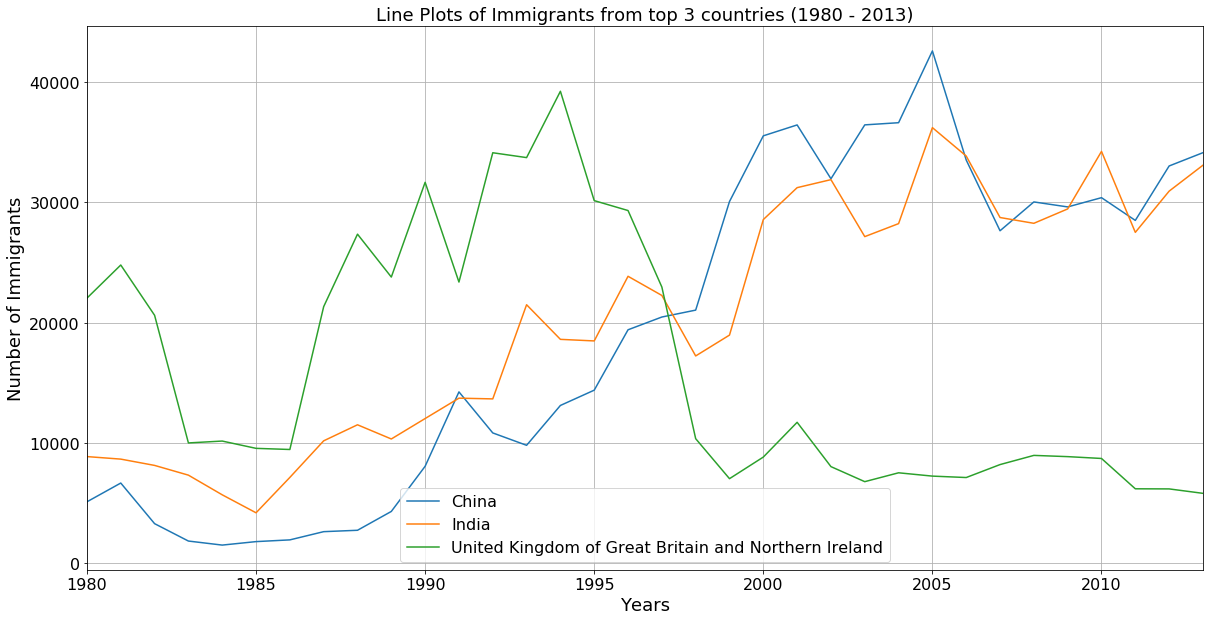

In [10]:
# Plot number of mmigrants against years
fig = plt.figure() # create figure
ax = fig.add_subplot(1, 1, 1) 
plt.tick_params(labelsize=16)

df_CIUK.plot(kind='line', figsize=(20, 10), ax=ax) 
ax.set_title ('Line Plots of Immigrants from top 3 countries (1980 - 2013)',fontsize=18)
ax.set_ylabel('Number of Immigrants',fontsize=18)
ax.set_xlabel('Years',fontsize=18)
ax.legend(prop=dict(size=16))
ax.grid(True)
plt.show()


### 3.Creat data of neighborhoods in Toronto

In [11]:
# getting data OF neighborhoods in Toronto from internet link
URL='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_data= requests.get(URL).text

soup = BeautifulSoup(raw_data,'xml')

table = soup.find('table')

In [12]:
table_raw=""
for tr in table.find_all('tr'):
    row1=""
    for tds in tr.find_all('td'):
        row1=row1+","+tds.text
    table_raw=table_raw+row1[1:]

In [13]:
# save data to csv
file=open("toronto_postalcodes.csv","wb")
file.write(bytes(table_raw,encoding="ascii",errors="ignore"))

6833

In [14]:
# import data into pd dataframe
# The table on above link is changed, so load csv from local folder
df = pd.read_csv('toronto_postalcodes_old.csv',header=None)
df.columns=["Postalcode","Borough","Neighborhood"]
df.head(12)

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,Islington Avenue


###### Data pre-processing and cleaning

In [15]:
indexNames = df[ df['Borough'] =='Not assigned'].index
df.drop(indexNames , inplace=True)
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [16]:
combine = df.groupby(['Postalcode','Borough'], sort=False).agg( ', '.join)
#reset the index
df_new=combine.reset_index()
df_new.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


###### Add geographical coordinates of each postal code from: http://cocl.us/Geospatial_data

In [17]:
!wget -q -O 'Geospatial_Coordinates.csv'  http://cocl.us/Geospatial_data
df_coor = pd.read_csv('Geospatial_Coordinates.csv')
df_coor.head()

'wget' is not recognized as an internal or external command,
operable program or batch file.


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
df_coor.columns = ['Postalcode','Latitude','Longitude']
df_toronto = pd.merge(df_new, df_coor, on = 'Postalcode')
df_toronto.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


In [19]:
df_tor= df_toronto.sort_values(['Postalcode','Borough','Neighborhood'], ascending=[1,0,0])
df_tor.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
12,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
18,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
22,M1G,Scarborough,Woburn,43.770992,-79.216917
26,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


###### Import the traffic information

In [20]:
URL='https://www.toronto.ca/ext/open_data/catalog/data_set_files/8hrVeh&PedVolume_6-Mar-2018.xlsx'
df_traffic=pd.read_excel(URL)
df_traffic.head()

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,2015-12-08,19678,4369
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,2016-09-17,14487,3368


In [21]:
df_traffic['PC']='Nan'
df_traffic.head()

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,PC
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535,Nan
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333,Nan
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083,Nan
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,2015-12-08,19678,4369,Nan
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,2016-09-17,14487,3368,Nan


In [22]:
df_traffic2=df_traffic.copy()
for  row1 in df_traffic2.iterrows():
    shortdist=100
    for  row2 in df_tor.iterrows():
        dist=(row1[1].Latitude-row2[1].Latitude)**2+(row1[1].Longitude-row2[1].Longitude)**2
        if dist<shortdist:
            shortdist=dist
            closestpc=row2[1].Postalcode
    df_traffic2.at[row1[0],'PC']=closestpc
df_traffic2.head()

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,PC
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535,M5C
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333,M5C
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083,M5C
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,2015-12-08,19678,4369,M5C
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,2016-09-17,14487,3368,M5C


In [23]:
df_traffic2.PC.get_values()

array(['M5C', 'M5C', 'M5C', ..., 'M6N', 'M1X', 'M1B'], dtype=object)

In [24]:
df_traffic3=df_traffic2.groupby(['PC']).mean()
df_traffic3=df_traffic3.reset_index()
df_traffic3.head()

,PC,TCS #,Latitude,Longitude,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,M1B,1686.315789,43.803058,-79.202146,11453.552632,725.052632
1,M1C,1629.120000,43.784289,-78.923751,9436.520000,457.640000
2,M1E,1160.285714,43.765703,-79.189726,15733.714286,781.666667
3,M1G,1288.392857,43.770180,-79.217162,14060.785714,706.035714
4,M1H,1333.400000,43.779115,-79.242165,18679.600000,584.057143


In [25]:
df_full=df_tor.merge(df_traffic3, left_on='Postalcode', right_on='PC')
df_full.head(10)

,Postalcode,Borough,Neighborhood,Latitude_x,Longitude_x,PC,TCS #,Latitude_y,Longitude_y,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,M1B,1686.315789,43.803058,-79.202146,11453.552632,725.052632
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,M1C,1629.120000,43.784289,-78.923751,9436.520000,457.640000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,M1E,1160.285714,43.765703,-79.189726,15733.714286,781.666667
3,M1G,Scarborough,Woburn,43.770992,-79.216917,M1G,1288.392857,43.770180,-79.217162,14060.785714,706.035714
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,M1H,1333.400000,43.779115,-79.242165,18679.600000,584.057143
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,M1J,1066.272727,43.745631,-79.235932,16726.090909,915.272727
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,M1K,1222.322581,43.728425,-79.263789,14189.129032,741.709677
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,M1L,1339.000000,43.713832,-79.287035,14976.093750,775.156250
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,M1M,952.142857,43.718548,-79.242370,17438.142857,639.000000
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,M1N,789.789474,43.696907,-79.269347,12161.736842,407.736842


###### Refine the column

In [26]:
df_full.drop(['PC','Latitude_y','Longitude_y'],axis=1,inplace=True)
df_full.head()

,Postalcode,Borough,Neighborhood,Latitude_x,Longitude_x,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1686.315789,11453.552632,725.052632
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1629.120000,9436.520000,457.640000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1288.392857,14060.785714,706.035714
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1333.400000,18679.600000,584.057143


In [27]:
df_full.rename(columns={'Latitude_x':'Latitude','Longitude_x':'Longitude'},inplace=True)

In [28]:
df_full.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1686.315789,11453.552632,725.052632
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1629.120000,9436.520000,457.640000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1288.392857,14060.785714,706.035714
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1333.400000,18679.600000,584.057143


In [30]:
df_full.to_csv('df_full_table.csv')

### 4.Call Foursquare API for restaurant information

In [41]:
CLIENT_ID = '5IAUHTNHUOHUW0GKYEEJYYCDSWJRHXK1DKY1UQGVSXKP0KMU' # your Foursquare ID
CLIENT_SECRET = 'I30HUQUW2FNERFFALWIW2UKXPP1NFGUT5G12GZYXVE3ZDRNJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [50]:
search_query = 'Restaurant'
radius = 1000
LIMIT = 100

Count=[]
for index,row in df_full.iterrows():
    latitude=row.Latitude
    longitude=row.Longitude
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    if index==0:
        dataframe = json_normalize(venues)
        dataframe['Postalcode']=row.Postalcode
        Count=Count+[dataframe.shape[0]]
    else:
        tempdataframe = json_normalize(venues)
        tempdataframe['Postalcode']=row.Postalcode
 
        dataframe=pd.concat([dataframe,tempdataframe],sort=True)
        Count=Count+[tempdataframe.shape[0]]

In [51]:
print(dataframe.shape)
dataframe.head()

(1406, 20)


,Postalcode,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,M1C,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",False,4be6c179d4f7c9b665042720,404 Old Kingston Rd.,CA,Scarborough,Canada,NaN,699.0,"[404 Old Kingston Rd., Scarborough ON, Canada]","[{'label': 'display', 'lat': 43.78446796744621...",43.784468,-79.169200,NaN,NaN,ON,Ted's Restaurant,v-1584582813,NaN
0,M1E,[],False,4b7054e3f964a5204d132de3,4379 Kingston Road,CA,Toronto,Canada,NaN,246.0,"[4379 Kingston Road, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.76535407, 'lng...",43.765354,-79.190536,NaN,NaN,ON,Wonder Season Chinese Restaurant,v-1584582814,NaN
1,M1E,[],False,4ea863ad5c5cc8e499272572,Gerrard Street,CA,Toronto,Canada,NaN,643.0,"[Gerrard Street, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.76934, 'lng': ...",43.769340,-79.188180,NaN,NaN,ON,Mahar Restaurant,v-1584582814,NaN
2,M1E,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,4ccc6b0dba0a5481623f3d59,4190 Kingston Road,CA,Toronto,Canada,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.759544, 'lng':...",43.759544,-79.198180,NaN,NaN,ON,Tai Chi Restaurant,v-1584582814,NaN
3,M1E,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,4c85aa5bee6fef3b1d1d3e5c,3103 Kingston Road,CA,Scarborough,Canada,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...","[{'label': 'display', 'lat': 43.77194591410752...",43.771946,-79.185976,Scarborough Village,M1E 2N8,ON,Peking Garden Restaurant,v-1584582814,NaN


In [56]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['Postalcode', 'name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,Postalcode,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,M1C,Ted's Restaurant,Breakfast Spot,404 Old Kingston Rd.,CA,Scarborough,Canada,NaN,699.0,"[404 Old Kingston Rd., Scarborough ON, Canada]","[{'label': 'display', 'lat': 43.78446796744621...",43.784468,-79.169200,NaN,NaN,ON,4be6c179d4f7c9b665042720
0,M1E,Wonder Season Chinese Restaurant,None,4379 Kingston Road,CA,Toronto,Canada,NaN,246.0,"[4379 Kingston Road, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.76535407, 'lng...",43.765354,-79.190536,NaN,NaN,ON,4b7054e3f964a5204d132de3
1,M1E,Mahar Restaurant,None,Gerrard Street,CA,Toronto,Canada,NaN,643.0,"[Gerrard Street, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.76934, 'lng': ...",43.769340,-79.188180,NaN,NaN,ON,4ea863ad5c5cc8e499272572
2,M1E,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,CA,Toronto,Canada,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.759544, 'lng':...",43.759544,-79.198180,NaN,NaN,ON,4ccc6b0dba0a5481623f3d59
3,M1E,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,CA,Scarborough,Canada,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...","[{'label': 'display', 'lat': 43.77194591410752...",43.771946,-79.185976,Scarborough Village,M1E 2N8,ON,4c85aa5bee6fef3b1d1d3e5c


In [57]:
restlist2=dataframe_filtered.copy()
restlist2.to_csv('Restaurant in Toronto.csv')

In [58]:
restlist2.reset_index(inplace=True)
restlist2=restlist2[['Postalcode', 'name', 'categories', 'address','city', 
       'crossStreet', 'distance', 'formattedAddress', 'lat',
       'lng', 'state', 'id']]
print(restlist2.shape)
restlist2.head(10)

(1406, 12)


,Postalcode,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id
0,M1C,Ted's Restaurant,Breakfast Spot,404 Old Kingston Rd.,Scarborough,NaN,699.0,"[404 Old Kingston Rd., Scarborough ON, Canada]",43.784468,-79.169200,ON,4be6c179d4f7c9b665042720
1,M1E,Wonder Season Chinese Restaurant,None,4379 Kingston Road,Toronto,NaN,246.0,"[4379 Kingston Road, Toronto ON, Canada]",43.765354,-79.190536,ON,4b7054e3f964a5204d132de3
2,M1E,Mahar Restaurant,None,Gerrard Street,Toronto,NaN,643.0,"[Gerrard Street, Toronto ON, Canada]",43.769340,-79.188180,ON,4ea863ad5c5cc8e499272572
3,M1E,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,Toronto,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]",43.759544,-79.198180,ON,4ccc6b0dba0a5481623f3d59
4,M1E,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,Scarborough,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...",43.771946,-79.185976,ON,4c85aa5bee6fef3b1d1d3e5c
5,M1E,McDonald's,Fast Food Restaurant,4435 Kingston Rd.,Scarborough,Lawrence Ave E,531.0,"[4435 Kingston Rd. (Lawrence Ave E), Scarborou...",43.768334,-79.188288,ON,4b9023e9f964a5200e7833e3
6,M1G,Sa-Fire Restaurant & Bar,Restaurant,308 Painted Post Drive,Toronto,Markham Rd,932.0,"[308 Painted Post Drive (Markham Rd), Toronto ...",43.768067,-79.227784,ON,5a35745d535d6f0cd05e15b6
7,M1G,Lucky Hakka,Chinese Restaurant,"3774 Lawrence Avenue East,",Scarborough,Lawrence & Scarborough Golf Club,974.0,"[3774 Lawrence Avenue East, (Lawrence & Scarbo...",43.762470,-79.214164,M1G 1P9,4b64765ff964a52028b52ae3
8,M1H,Federick Restaurant,Hakka Restaurant,1920 Ellesmere Rd,Scarborough,at Bellamy Rd. N,219.0,"[1920 Ellesmere Rd (at Bellamy Rd. N), Scarbor...",43.774697,-79.241142,ON,4b1711a6f964a520cbc123e3
9,M1H,Terry's Restaurant & Bar,Restaurant,1920 Ellesmere Rd,Scarborough,Bellamy Road,222.0,"[1920 Ellesmere Rd (Bellamy Road), Scarborough...",43.774780,-79.241043,ON,551838f6498ee39ec286ba6e


In [59]:
restlist2.dtypes

Postalcode           object
name                 object
categories           object
address              object
city                 object
crossStreet          object
distance            float64
formattedAddress     object
lat                 float64
lng                 float64
state                object
id                   object
dtype: object

In [60]:
rest_count=restlist2['categories'].value_counts()
rest_count.head()

Restaurant             226
Chinese Restaurant     180
Indian Restaurant       63
Japanese Restaurant     58
Italian Restaurant      53
Name: categories, dtype: int64

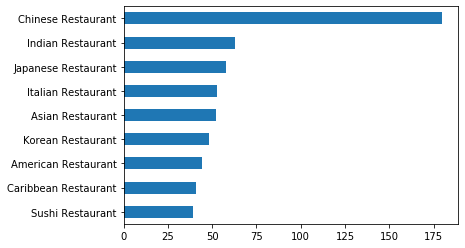

In [61]:
restlist2['categories'].value_counts()[1:10].sort_values().plot(kind='barh')

In [62]:
ChiRes =restlist2[restlist2['categories'] == 'Chinese Restaurant'].reset_index(drop=True)
ChiRes.head()

,Postalcode,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id
0,M1E,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,Toronto,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]",43.759544,-79.198180,ON,4ccc6b0dba0a5481623f3d59
1,M1E,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,Scarborough,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...",43.771946,-79.185976,ON,4c85aa5bee6fef3b1d1d3e5c
2,M1G,Lucky Hakka,Chinese Restaurant,"3774 Lawrence Avenue East,",Scarborough,Lawrence & Scarborough Golf Club,974.0,"[3774 Lawrence Avenue East, (Lawrence & Scarbo...",43.762470,-79.214164,M1G 1P9,4b64765ff964a52028b52ae3
3,M1K,Good Luck Chinese Restaurant,Chinese Restaurant,NaN,Toronto,Kennedy,704.0,"[Toronto ON, Canada]",43.733297,-79.266668,ON,4bd784e40b779c747a6e05a0
4,M1M,Super Choy Restaurant,Chinese Restaurant,NaN,Scarboroigh,2825 Kingston Road,597.0,"[Scarboroigh ON, Canada]",43.721289,-79.236698,ON,4d1124c599b78cfa529fc7d5


In [88]:
ChiRes.shape

(177, 12)

In [63]:
ChiRes.to_csv('Chinese Restaurant in Toronto.csv')

###### Add the number of Chinese restaurants found in each Borough

In [69]:
ChiRes2=ChiRes.sort_values('distance',ascending=False)
ChiRes2=ChiRes2.drop_duplicates(subset='name', keep='last')
ChiRes2=ChiRes2.reset_index(drop=True)
print(ChiRes2.shape)
ChiRes2.head()

(100, 12)


,Postalcode,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id
0,M4B,Golden Wok Restaurant,Chinese Restaurant,94 Halsley Dr,East York,NaN,1201.0,"[94 Halsley Dr, East York ON, Canada]",43.700601,-79.297343,ON,50edcd30e4b0372659fcb29a
1,M2R,Szechuan Gourmet Restaurant,Chinese Restaurant,1033 Steeles Ave. W.,North York,at Carpenter Rd.,1092.0,"[1033 Steeles Ave. W. (at Carpenter Rd.), Nort...",43.791620,-79.448052,ON,4b637f5cf964a5207f7e2ae3
2,M1R,Super Hakka Restaurant,Chinese Restaurant,1801 Lawrence Ave E,NaN,NaN,1083.0,"[1801 Lawrence Ave E, M1R 2X7, Canada]",43.742892,-79.304949,NaN,5269be82498e1cf7de5d5dd4
3,M4M,Jin Jin Chinese Restaurant,Chinese Restaurant,NaN,Toronto,NaN,1059.0,"[Toronto ON, Canada]",43.665467,-79.351200,ON,4e3348e988772aabd8ab1335
4,M6M,Green Island Chinese Restaurant,Chinese Restaurant,572 Rogers Rd,Toronto,Keele & Rogera,1057.0,"[572 Rogers Rd (Keele & Rogera), Toronto ON M6...",43.682164,-79.471603,ON,4c9e81e6542b224b7eecf49f


In [74]:
ChiRes3=df_full.merge(ChiRes2, left_on='Postalcode', right_on='Postalcode', how='left')
print(ChiRes3.shape)
ChiRes3.head()

(160, 19)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1686.315789,11453.552632,725.052632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1629.120000,9436.520000,457.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,Scarborough,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...",43.771946,-79.185976,ON,4c85aa5bee6fef3b1d1d3e5c
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,Toronto,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]",43.759544,-79.198180,ON,4ccc6b0dba0a5481623f3d59
4,M1G,Scarborough,Woburn,43.770992,-79.216917,1288.392857,14060.785714,706.035714,Lucky Hakka,Chinese Restaurant,"3774 Lawrence Avenue East,",Scarborough,Lawrence & Scarborough Golf Club,974.0,"[3774 Lawrence Avenue East, (Lawrence & Scarbo...",43.762470,-79.214164,M1G 1P9,4b64765ff964a52028b52ae3


In [75]:
ChiRes_Total =ChiRes3[ChiRes3['categories'] == 'Chinese Restaurant'].reset_index(drop=True)
print(ChiRes_Total.shape)
ChiRes_Total.head()

(100, 19)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id
0,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,Scarborough,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...",43.771946,-79.185976,ON,4c85aa5bee6fef3b1d1d3e5c
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,Toronto,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]",43.759544,-79.198180,ON,4ccc6b0dba0a5481623f3d59
2,M1G,Scarborough,Woburn,43.770992,-79.216917,1288.392857,14060.785714,706.035714,Lucky Hakka,Chinese Restaurant,"3774 Lawrence Avenue East,",Scarborough,Lawrence & Scarborough Golf Club,974.0,"[3774 Lawrence Avenue East, (Lawrence & Scarbo...",43.762470,-79.214164,M1G 1P9,4b64765ff964a52028b52ae3
3,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1222.322581,14189.129032,741.709677,Good Luck Chinese Restaurant,Chinese Restaurant,NaN,Toronto,Kennedy,704.0,"[Toronto ON, Canada]",43.733297,-79.266668,ON,4bd784e40b779c747a6e05a0
4,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,952.142857,17438.142857,639.000000,Super Choy Restaurant,Chinese Restaurant,NaN,Scarboroigh,2825 Kingston Road,597.0,"[Scarboroigh ON, Canada]",43.721289,-79.236698,ON,4d1124c599b78cfa529fc7d5


In [77]:
ChiRes_count=ChiRes_Total.groupby('Borough').count()
ChiRes_count=ChiRes_count.reset_index(drop=False)
ChiRes_count=ChiRes_count[['Borough','categories']].copy()
ChiRes_count.columns=['Borough','Number of Chinese Restaurants']
ChiRes_count

,Borough,Number of Chinese Restaurants
0,Central Toronto,3
1,Downtown Toronto,34
2,East Toronto,4
3,East York,5
4,Etobicoke,2
5,Mississauga,1
6,North York,13
7,Scarborough,32
8,West Toronto,3
9,York,3


In [84]:
ChiRes_count.sort_values(by='Number of Chinese Restaurants',ascending=False,inplace=True)
ChiRes_count=ChiRes_count.reset_index(drop=True)
ChiRes_count

,Borough,Number of Chinese Restaurants
0,Downtown Toronto,34
1,Scarborough,32
2,North York,13
3,East York,5
4,East Toronto,4
5,Central Toronto,3
6,West Toronto,3
7,York,3
8,Etobicoke,2
9,Mississauga,1


###### Add tips and rating to Chinese Restaurants

In [86]:
for index, row in ChiRes_Total.iterrows():
    venue_id = '{}'.format(row.id) 
    name='{}'.format(ChiRes_Total.name[index]) 
    print(name,' id number: ',venue_id)
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()

    ChiRes_Total.loc[index, 'numbertips']=result['response']['venue']['tips']['count']
    try:
        ChiRes_Total.loc[index, 'rating']=result['response']['venue']['rating'] 
        print(name, ' has a rating of ',result['response']['venue']['rating'] )
    except:
        print(name, ' has no rating  ')
    print('Number of tips in ', name,': ', result['response']['venue']['tips']['count'])


Peking Garden Restaurant  id number:  4c85aa5bee6fef3b1d1d3e5c
Peking Garden Restaurant  has no rating  
Number of tips in  Peking Garden Restaurant :  5
Tai Chi Restaurant  id number:  4ccc6b0dba0a5481623f3d59
Tai Chi Restaurant  has no rating  
Number of tips in  Tai Chi Restaurant :  1
Lucky Hakka  id number:  4b64765ff964a52028b52ae3
Lucky Hakka  has a rating of  6.0
Number of tips in  Lucky Hakka :  9
Good Luck Chinese Restaurant  id number:  4bd784e40b779c747a6e05a0
Good Luck Chinese Restaurant  has no rating  
Number of tips in  Good Luck Chinese Restaurant :  0
Super Choy Restaurant  id number:  4d1124c599b78cfa529fc7d5
Super Choy Restaurant  has no rating  
Number of tips in  Super Choy Restaurant :  2
Lucky Chinese (Haka) Restaurant  id number:  4bafb9cbf964a520691b3ce3
Lucky Chinese (Haka) Restaurant  has a rating of  6.7
Number of tips in  Lucky Chinese (Haka) Restaurant :  5
Kim Kim restaurant  id number:  4b6475aef964a520eab42ae3
Kim Kim restaurant  has a rating of  7.4
N

KeyError: 'venue'

In [88]:
ChiRes_Total.to_csv('Chinese Restaurant in Toronto with rating.csv')

In [92]:
ChiRes_Total_rating=ChiRes_Total.copy()
print(ChiRes_Total_rating.shape)
ChiRes_Total_rating.head()

(100, 21)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id,numbertips,rating
0,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,Scarborough,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...",43.771946,-79.185976,ON,4c85aa5bee6fef3b1d1d3e5c,5.0,NaN
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,Toronto,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]",43.759544,-79.198180,ON,4ccc6b0dba0a5481623f3d59,1.0,NaN
2,M1G,Scarborough,Woburn,43.770992,-79.216917,1288.392857,14060.785714,706.035714,Lucky Hakka,Chinese Restaurant,"3774 Lawrence Avenue East,",Scarborough,Lawrence & Scarborough Golf Club,974.0,"[3774 Lawrence Avenue East, (Lawrence & Scarbo...",43.762470,-79.214164,M1G 1P9,4b64765ff964a52028b52ae3,9.0,6.0
3,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1222.322581,14189.129032,741.709677,Good Luck Chinese Restaurant,Chinese Restaurant,NaN,Toronto,Kennedy,704.0,"[Toronto ON, Canada]",43.733297,-79.266668,ON,4bd784e40b779c747a6e05a0,0.0,NaN
4,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,952.142857,17438.142857,639.000000,Super Choy Restaurant,Chinese Restaurant,NaN,Scarboroigh,2825 Kingston Road,597.0,"[Scarboroigh ON, Canada]",43.721289,-79.236698,ON,4d1124c599b78cfa529fc7d5,2.0,NaN


In [93]:
ChiRes_Total_rating['rating'].fillna(5, inplace=True)
ChiRes_Total_rating.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id,numbertips,rating
0,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Peking Garden Restaurant,Chinese Restaurant,3103 Kingston Road,Scarborough,McCowan,957.0,"[3103 Kingston Road (McCowan), Scarborough ON ...",43.771946,-79.185976,ON,4c85aa5bee6fef3b1d1d3e5c,5.0,5.0
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1160.285714,15733.714286,781.666667,Tai Chi Restaurant,Chinese Restaurant,4190 Kingston Road,Toronto,NaN,883.0,"[4190 Kingston Road, Toronto ON, Canada]",43.759544,-79.198180,ON,4ccc6b0dba0a5481623f3d59,1.0,5.0
2,M1G,Scarborough,Woburn,43.770992,-79.216917,1288.392857,14060.785714,706.035714,Lucky Hakka,Chinese Restaurant,"3774 Lawrence Avenue East,",Scarborough,Lawrence & Scarborough Golf Club,974.0,"[3774 Lawrence Avenue East, (Lawrence & Scarbo...",43.762470,-79.214164,M1G 1P9,4b64765ff964a52028b52ae3,9.0,6.0
3,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1222.322581,14189.129032,741.709677,Good Luck Chinese Restaurant,Chinese Restaurant,NaN,Toronto,Kennedy,704.0,"[Toronto ON, Canada]",43.733297,-79.266668,ON,4bd784e40b779c747a6e05a0,0.0,5.0
4,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,952.142857,17438.142857,639.000000,Super Choy Restaurant,Chinese Restaurant,NaN,Scarboroigh,2825 Kingston Road,597.0,"[Scarboroigh ON, Canada]",43.721289,-79.236698,ON,4d1124c599b78cfa529fc7d5,2.0,5.0


In [99]:
ChiRes_Total_rating.sort_values(by='rating',ascending=False,inplace=True)
ChiRes_Total_rating.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id,numbertips,rating
20,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,1234.419355,21932.774194,868.419355,The Royal Chinese Restaurant 避風塘小炒,Chinese Restaurant,3587 Sheppard Ave E,Toronto,Birchmount Rd,456.0,"[3587 Sheppard Ave E (Birchmount Rd), Toronto ...",43.780505,-79.298844,ON,4cdc8e53d4ecb1f7843c8048,11.0,7.7
6,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,1336.088235,18873.294118,615.382353,Kim Kim restaurant,Chinese Restaurant,1188 Kennedy Rd,Scarborough,NaN,478.0,"[1188 Kennedy Rd, Scarborough ON M1P 2L1, Canada]",43.753833,-79.276611,ON,4b6475aef964a520eab42ae3,29.0,7.4
7,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,1321.333333,20663.366667,758.633333,Super Hakka Restaurant,Chinese Restaurant,1801 Lawrence Ave E,NaN,NaN,1083.0,"[1801 Lawrence Ave E, M1R 2X7, Canada]",43.742892,-79.304949,NaN,5269be82498e1cf7de5d5dd4,5.0,7.1
30,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,1460.081633,16837.346939,686.061224,Phoenix Restaurant 金鳳餐廳,Chinese Restaurant,2900 Warden Ave,Scarborough,at Finch Ave E,147.0,"[2900 Warden Ave (at Finch Ave E), Scarborough...",43.798198,-79.318432,ON,5542be72498e851f264ce89a,4.0,6.9
38,M2R,North York,Willowdale West,43.782736,-79.442259,1331.760000,20880.640000,1144.440000,Szechuan Gourmet Restaurant,Chinese Restaurant,1033 Steeles Ave. W.,North York,at Carpenter Rd.,1092.0,"[1033 Steeles Ave. W. (at Carpenter Rd.), Nort...",43.791620,-79.448052,ON,4b637f5cf964a5207f7e2ae3,8.0,6.9


In [133]:
ChiRes_Total_rating['popup']=ChiRes_Total_rating['name'].astype(str)+'/ '+ChiRes_Total_rating['rating'].astype(str)
ChiRes_Total_rating.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id,numbertips,rating,popup
20,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,1234.419355,21932.774194,868.419355,The Royal Chinese Restaurant 避風塘小炒,Chinese Restaurant,3587 Sheppard Ave E,Toronto,Birchmount Rd,456.0,"[3587 Sheppard Ave E (Birchmount Rd), Toronto ...",43.780505,-79.298844,ON,4cdc8e53d4ecb1f7843c8048,11.0,7.7,The Royal Chinese Restaurant 避風塘小炒/ 7.7
6,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,1336.088235,18873.294118,615.382353,Kim Kim restaurant,Chinese Restaurant,1188 Kennedy Rd,Scarborough,NaN,478.0,"[1188 Kennedy Rd, Scarborough ON M1P 2L1, Canada]",43.753833,-79.276611,ON,4b6475aef964a520eab42ae3,29.0,7.4,Kim Kim restaurant/ 7.4
7,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,1321.333333,20663.366667,758.633333,Super Hakka Restaurant,Chinese Restaurant,1801 Lawrence Ave E,NaN,NaN,1083.0,"[1801 Lawrence Ave E, M1R 2X7, Canada]",43.742892,-79.304949,NaN,5269be82498e1cf7de5d5dd4,5.0,7.1,Super Hakka Restaurant/ 7.1
30,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,1460.081633,16837.346939,686.061224,Phoenix Restaurant 金鳳餐廳,Chinese Restaurant,2900 Warden Ave,Scarborough,at Finch Ave E,147.0,"[2900 Warden Ave (at Finch Ave E), Scarborough...",43.798198,-79.318432,ON,5542be72498e851f264ce89a,4.0,6.9,Phoenix Restaurant 金鳳餐廳/ 6.9
38,M2R,North York,Willowdale West,43.782736,-79.442259,1331.760000,20880.640000,1144.440000,Szechuan Gourmet Restaurant,Chinese Restaurant,1033 Steeles Ave. W.,North York,at Carpenter Rd.,1092.0,"[1033 Steeles Ave. W. (at Carpenter Rd.), Nort...",43.791620,-79.448052,ON,4b637f5cf964a5207f7e2ae3,8.0,6.9,Szechuan Gourmet Restaurant/ 6.9


In [109]:
ChiRes_Total_rating_top=ChiRes_Total_rating[['Borough','name','rating','numbertips']].copy()
ChiRes_Total_rating_top.index = np.arange(1, len(ChiRes_Total_rating_top)+1)
ChiRes_Total_rating_top.head(10)

,Borough,name,rating,numbertips
1,Scarborough,The Royal Chinese Restaurant 避風塘小炒,7.7,11.0
2,Scarborough,Kim Kim restaurant,7.4,29.0
3,Scarborough,Super Hakka Restaurant,7.1,5.0
4,Scarborough,Phoenix Restaurant 金鳳餐廳,6.9,4.0
5,North York,Szechuan Gourmet Restaurant,6.9,8.0
6,Scarborough,Lucky Chinese (Haka) Restaurant,6.7,5.0
7,North York,Lee Town Restaurant,6.5,6.0
8,Scarborough,Perfect Chinese Restaurant 雅瓊海鮮酒家,6.3,42.0
9,Scarborough,Lucky Hakka,6.0,9.0
10,Scarborough,Fortune Restaurant,5.8,1.0


In [113]:
ChiRes_final=ChiRes_Total_rating.reset_index(drop=True)
print(ChiRes_final.shape)
ChiRes_final.head()
ChiRes_final.to_csv('ChiRes_final.csv')

(100, 21)


###### Plot Folium Map for the Chinese Restaurants in Toronto

In [104]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [114]:
map_ChiRes = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(ChiRes_final['Latitude'], ChiRes_final['Longitude'], ChiRes_final['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ChiRes)  
    
map_ChiRes

In [135]:
map_ChiRes_pop = folium.Map(location=[latitude,longitude], zoom_start=12)

incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(ChiRes_Total_rating.Latitude, ChiRes_Total_rating.Longitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(ChiRes_Total_rating.Latitude)
longitudes = list(ChiRes_Total_rating.Longitude)
labels = list(ChiRes_Total_rating.popup)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=folium.Popup(str(label), parse_html=True)).add_to(map_ChiRes_pop)    
    
# add incidents to map
map_ChiRes_pop.add_child(incidents)

###### K-means to generate 4 clusters based on the average pedestrian and vehicule traffic in each Postalcode area

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [124]:
ChiRes_final.rename(columns={'8 Peak Hr Vehicle Volume':'Vehicle_V','8 Peak Hr Pedestrian Volume':'Pedestrian_V'},inplace=True)
ChiRes_final.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,Vehicle_V,Pedestrian_V,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id,numbertips,rating
0,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,1234.419355,21932.774194,868.419355,The Royal Chinese Restaurant 避風塘小炒,Chinese Restaurant,3587 Sheppard Ave E,Toronto,Birchmount Rd,456.0,"[3587 Sheppard Ave E (Birchmount Rd), Toronto ...",43.780505,-79.298844,ON,4cdc8e53d4ecb1f7843c8048,11.0,7.7
1,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,1336.088235,18873.294118,615.382353,Kim Kim restaurant,Chinese Restaurant,1188 Kennedy Rd,Scarborough,NaN,478.0,"[1188 Kennedy Rd, Scarborough ON M1P 2L1, Canada]",43.753833,-79.276611,ON,4b6475aef964a520eab42ae3,29.0,7.4
2,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,1321.333333,20663.366667,758.633333,Super Hakka Restaurant,Chinese Restaurant,1801 Lawrence Ave E,NaN,NaN,1083.0,"[1801 Lawrence Ave E, M1R 2X7, Canada]",43.742892,-79.304949,NaN,5269be82498e1cf7de5d5dd4,5.0,7.1
3,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,1460.081633,16837.346939,686.061224,Phoenix Restaurant 金鳳餐廳,Chinese Restaurant,2900 Warden Ave,Scarborough,at Finch Ave E,147.0,"[2900 Warden Ave (at Finch Ave E), Scarborough...",43.798198,-79.318432,ON,5542be72498e851f264ce89a,4.0,6.9
4,M2R,North York,Willowdale West,43.782736,-79.442259,1331.760000,20880.640000,1144.440000,Szechuan Gourmet Restaurant,Chinese Restaurant,1033 Steeles Ave. W.,North York,at Carpenter Rd.,1092.0,"[1033 Steeles Ave. W. (at Carpenter Rd.), Nort...",43.791620,-79.448052,ON,4b637f5cf964a5207f7e2ae3,8.0,6.9


In [125]:
cluster=ChiRes_final[['Vehicle_V','Pedestrian_V']]
cluster=cluster.astype(float)
cluster = np.nan_to_num(cluster)
cluster_dataset = StandardScaler().fit_transform(cluster)

In [126]:
num_clusters = 4
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
print(labels)

[1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 3 1 0 0 0
 0 0 1 1 1 1 1 0 0 1 0 0 0 0 3 0 0 3 3 3 3 2 2 2 2 2 2 2 3 3 3 0 2 3 3 3 3
 0 3 3 3 3 3 0 3 3 3 3 3 3 3 1 3 3 3 0 0 0 3 0 0 3 0]


In [127]:
ChiRes_labels=ChiRes_final.copy()
ChiRes_labels['labels']=labels
print(ChiRes_labels.shape)
ChiRes_labels.head()

(100, 22)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,TCS #,Vehicle_V,Pedestrian_V,name,categories,address,city,crossStreet,distance,formattedAddress,lat,lng,state,id,numbertips,rating,labels
0,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,1234.419355,21932.774194,868.419355,The Royal Chinese Restaurant 避風塘小炒,Chinese Restaurant,3587 Sheppard Ave E,Toronto,Birchmount Rd,456.0,"[3587 Sheppard Ave E (Birchmount Rd), Toronto ...",43.780505,-79.298844,ON,4cdc8e53d4ecb1f7843c8048,11.0,7.7,1
1,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,1336.088235,18873.294118,615.382353,Kim Kim restaurant,Chinese Restaurant,1188 Kennedy Rd,Scarborough,NaN,478.0,"[1188 Kennedy Rd, Scarborough ON M1P 2L1, Canada]",43.753833,-79.276611,ON,4b6475aef964a520eab42ae3,29.0,7.4,1
2,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,1321.333333,20663.366667,758.633333,Super Hakka Restaurant,Chinese Restaurant,1801 Lawrence Ave E,NaN,NaN,1083.0,"[1801 Lawrence Ave E, M1R 2X7, Canada]",43.742892,-79.304949,NaN,5269be82498e1cf7de5d5dd4,5.0,7.1,1
3,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,1460.081633,16837.346939,686.061224,Phoenix Restaurant 金鳳餐廳,Chinese Restaurant,2900 Warden Ave,Scarborough,at Finch Ave E,147.0,"[2900 Warden Ave (at Finch Ave E), Scarborough...",43.798198,-79.318432,ON,5542be72498e851f264ce89a,4.0,6.9,0
4,M2R,North York,Willowdale West,43.782736,-79.442259,1331.760000,20880.640000,1144.440000,Szechuan Gourmet Restaurant,Chinese Restaurant,1033 Steeles Ave. W.,North York,at Carpenter Rd.,1092.0,"[1033 Steeles Ave. W. (at Carpenter Rd.), Nort...",43.791620,-79.448052,ON,4b637f5cf964a5207f7e2ae3,8.0,6.9,1


In [129]:
ChiRes_dense_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centred around the Conrad Hotel

group0 =folium.FeatureGroup(name='<span style=\\"color: blue;\\"> High Vehicle, Low pedestrian</span>')
group1 =folium.FeatureGroup(name='<span style=\\"color: red;\\">Mid Vehicle, Low pedestrian</span>')
group2 =folium.FeatureGroup(name='<span style=\\"color: green;\\">High Vehicle, High pedestrian</span>')
group3 =folium.FeatureGroup(name='<span style=\\"color: orange;\\"> Mid Vehicle, Mid pedestrian</span>')

for lat, lng, bor, veh, ped, label in zip(ChiRes_labels.Latitude, ChiRes_labels.Longitude, ChiRes_labels.Borough, ChiRes_labels.Vehicle_V, ChiRes_labels.Pedestrian_V, ChiRes_labels.labels):
        # We restrict to those Boroughs that contain the word Toronto
        #Reason, if I leave all Boroughs the map doesn't load
        #Try in a future with a larger subset
        
            if label==0:
                clr='blue'
                folium.features.CircleMarker(
                    [lat, lng],
                    radius=2,
                    color=clr,
                    popup=bor+', '+str(int(veh))+ ' veh, '+str(int(ped))+' ped',
                    fill = True,
                    fill_color=clr,
                    fill_opacity=0.6
                ).add_to(group0)
            elif label==1:
                clr='red'
                folium.features.CircleMarker(
                    [lat, lng],
                    radius=2,
                    color=clr,
                    popup=bor+', '+str(int(veh))+ ' veh, '+str(int(ped))+' ped',
                    fill = True,
                    fill_color=clr,
                    fill_opacity=0.6
                ).add_to(group1)
            elif label==2:
                clr='green'
                folium.features.CircleMarker(
                    [lat, lng],
                    radius=2,
                    color=clr,
                    popup=bor+', '+str(int(veh))+ ' veh, '+str(int(ped))+' ped',
                    fill = True,
                    fill_color=clr,
                    fill_opacity=0.6
                ).add_to(group2)
            elif label==3:
                clr='orange'
                folium.features.CircleMarker(
                    [lat, lng],
                    radius=2,
                    color=clr,
                    popup=bor+', '+str(int(veh))+ ' veh, '+str(int(ped))+' ped',
                    fill = True,
                    fill_color=clr,
                    fill_opacity=0.6
                ).add_to(group3)
            elif label==4:
                clr='olivedrab1'
            elif label==5:
                clr='yellow'
            elif label==6:
                clr='turquise'
            elif label==7:
                clr='red'
            else:
                clr='black'
                folium.features.CircleMarker(
                    [lat, lng],
                    radius=2,
                    color=clr,
                    popup=bor+', '+str(int(veh))+ ' veh, '+str(int(ped))+' ped',
                    fill = True,
                    fill_color=clr,
                    fill_opacity=0.6
                ).add_to(toronto_traffic_dense_map)
group0.add_to(ChiRes_dense_map)
group1.add_to(ChiRes_dense_map)
group2.add_to(ChiRes_dense_map)
group3.add_to(ChiRes_dense_map)

folium.LayerControl('topright', collapsed=False).add_to(ChiRes_dense_map)

# display map
ChiRes_dense_map